In [1]:
import numpy as np
import random

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
Nb_model = 10

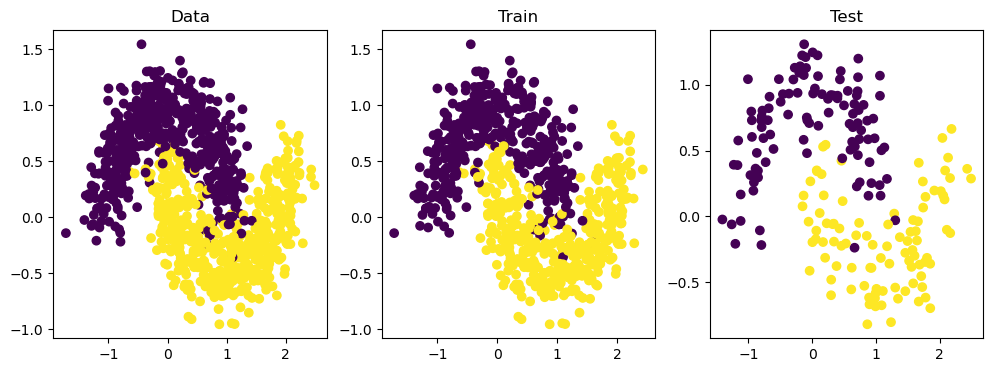

In [3]:
X, Y = make_moons(n_samples=1000, noise=0.2)


Y_formated = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42, test_size=0.2)
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title("Train")
plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)
plt.title("Test")
plt.show()


On va trier les points par rapport à leur abscisse, pour simuler un effet de proximité entre les points, et utiliser cette proximité pour délimiter les différents agents.

In [4]:
def split_horizontally(X, y, num_subsets=10):   
    indices = np.argsort(X[:, 0])

    X = X[indices]
    y = y[indices]

    limiteParAgent = np.random.choice(range(1, X.shape[0]), num_subsets-1, replace=False)
    limiteParAgent = np.sort(limiteParAgent)
    print(limiteParAgent)

    X_agent = []
    Y_agent = []

    for i in range(num_subsets):
        if i == 0:
            X_agent.append(X[:limiteParAgent[i]])
            Y_agent.append(y[:limiteParAgent[i]])
        elif i == Nb_model-1:
            X_agent.append(X[limiteParAgent[i-1]:])
            Y_agent.append(y[limiteParAgent[i-1]:])
        else:
            X_agent.append(X[limiteParAgent[i-1]:limiteParAgent[i]])
            Y_agent.append(y[limiteParAgent[i-1]:limiteParAgent[i]])

    return X_agent, Y_agent

In [5]:
def split_into_random_subsets(X, y, num_subsets=10, random_state=42):
    # Combine X and y to maintain correspondence
    data = np.column_stack((X, y))
    
    # Shuffle the combined data
    if random_state is not None:
        np.random.seed(random_state)
    np.random.shuffle(data)
    
    # Generate random sizes for the subsets
    random_sizes = np.random.rand(num_subsets)  # Random values
    random_sizes /= random_sizes.sum()  # Normalize to sum to 1
    random_sizes = (random_sizes * len(data)).astype(int)  # Scale to dataset size
    
    # Adjust sizes to ensure they sum exactly to len(data)
    random_sizes[-1] += len(data) - random_sizes.sum()
    
    # Split the data into subsets
    subsets = []
    start_idx = 0
    for size in random_sizes:
        subsets.append(data[start_idx:start_idx + size])
        start_idx += size
    
    # Separate X and y in each subset
    subsets_X = [subset[:, :-1] for subset in subsets]
    subsets_y = [subset[:, -1] for subset in subsets]
    
    return subsets_X, subsets_y

[ 35 202 297 309 353 447 515 686 744]


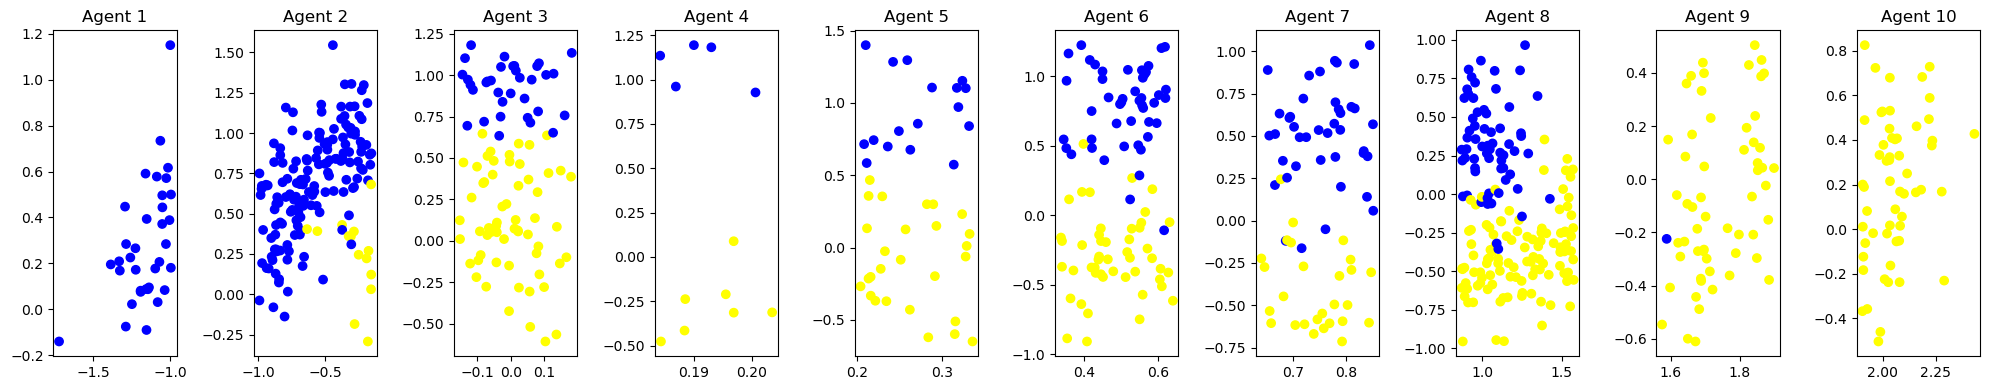

In [6]:

#X_agent, Y_agent = split_into_random_subsets(X_train, Y_train)
X_agent, Y_agent = split_horizontally(X_train, Y_train)


fig, axes = plt.subplots(nrows=1, ncols=Nb_model, figsize=(20, 4))

for i in range(Nb_model):
    colors = ['blue' if y== 0 else 'yellow' for y in Y_agent[i]]
    axes[i].scatter(X_agent[i][:,0], X_agent[i][:,1], c=colors)
    axes[i].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.show()

In [7]:
X_agent_augmented = []
for i in range(Nb_model):
    X_agent_augmented.append(np.concatenate([X_agent[i], X_agent[i]**2, X_agent[i]**3, X_agent[i]**4], axis=1))

In [8]:
X_test_augmented = np.concatenate([X_test, X_test**2, X_test**3, X_test**4], axis=1)

In [9]:
G = np.zeros((Nb_model, Nb_model))
for i in range(Nb_model):
    for j in range(Nb_model):
        if j == i+1 or j == i-1:
            G[i,j] = 1  
    
D = np.zeros(Nb_model)
c = np.zeros(Nb_model)

maxSize = np.max([x.shape[0] for x in X_agent])
print(f"Max: {maxSize}")
minSize = np.min([x.shape[0] for x in X_agent])
print(f"Min: {minSize}")
meanSize = np.mean([x.shape[0] for x in X_agent])
print(f"Mean: {meanSize}")
for i in range(Nb_model):
    D[i] = np.sum(G[i,:])
    c[i] = X_agent[i].shape[0]/maxSize



Max: 171
Min: 12
Mean: 80.0


supposons que l'on réveille d'abord les agents chacun leur tour.

In [10]:
T = 10000
mu = 0.05

## Logistic Regression and Gradient Descent


In linear regression, we got a real-valued response
	
$$\hat{y} = \theta_0 + \theta_1 x_1 + \cdots + \theta_d x_d,$$
    
i.e., a linear combination of inputs, where $\hat{y} \in \mathbf{R}$.

In classification, we want an *indication* of how likely an instance is to belong to a particular class; a probability $\in [0,1]$.  

Given a real valued $z$, we can squish it to range $\sigma(z) \in [0,1]$ by feeding it through the **logistic function** aka **sigmoid function**:
		
\begin{equation}
\sigma(z) = \frac{1}{1+\exp(-z)}. \hspace{1.5cm}(1)
\end{equation}

Which looks like this: ![Sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

Therefore, we can treat this as a probability, i.e.,

\begin{align*}
P(y=1|\mathbf{x}) &= \sigma(\mathbf{\theta}^\top\mathbf{x}), \\
P(y=0|\mathbf{x}) &= 1 - \sigma(\mathbf{\theta}^\top\mathbf{x}), 
\end{align*}

where we omit the bias term and suppose that both $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors.

In [11]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """The sigmoid function.
    
    Parameters
    ----------
    z : np.ndarray
        The array on which to elementwise compute the sigmoid function

    Returns
    -------
    np.ndarray
        The sigmoid value (1 / (1 + exp(-z)))
    """
    z = np.clip(z, -10, 10)
    return   1 / (1 + np.exp(-z))

In order to chose values for the parameters of logistic regression, we use **maximum likelihood estimation** (MLE). As such we are going to have two steps:

1. write the likelihood function;
2. find the values of $\theta$ that maximize the log-likelihood function.


We begin by defining the design matrix $X \in \mathbb{R}^{n,d}$ containing our data points $x_i^T \in \mathbb{R}^{1\times d}$ on its rows and our column vector of model paramters $\theta \in \mathbb{R}^{d\times 1}.$
The labels that we are predicting are binary, this means that we can interpret each label as a Bernoulli random variable: $Y \sim Ber(p)$ where $p = \sigma(\mathbf{\theta}^\top\mathbf{x})$.

Therefore, we can write the probability of a data point as
$$
P\left(Y=y|X=\mathbf{x}\right) = \sigma(\mathbf{\theta}^\top\mathbf{x})^y \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x})\right]^{(1-y)}.
$$

Given this probability mass function we can now write the **likelihood** of the whole dataset

\begin{equation}
L(\theta) = \prod_{i=1}^n P(Y = y_i|\mathbf{X} = \mathbf{x}_i) = \prod_{i=1}^n \sigma(\mathbf{\theta}^\top\mathbf{x}_i)^{y_i} \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]^{(1-y_i)}. \hspace{1.5cm}(2)
\end{equation}

We can take the log of this function to transform the product into a sum and by doing that, we obtain the **log-likelihood**

\begin{equation}
LL(\theta) = \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right). \hspace{1.5cm}(3)
\end{equation}

As you will remember from the first lab, our objective is to minimize the error by fitting our model to the data. However, the log-likelihood increases when the model is fitting better to the data. That's the reason why in logistic regression we take the *negative* log-likelihood (also known as **cost** function $E(\theta)$).

In [12]:
def cost(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> float:
    """Computes the cost using theta as the parameters for logistic regression.
    
    Parameters
    ----------
    theta : np.ndarray
        The parameters of the logit regression, of shape (n_features,)
    X : np.ndarray
        The points, of shape (n_sample, n_features)
    y : np.ndarray
        The labels, of shape (n_sample, 1)

    Returns
    -------
    float
        The sum of the cost for each sample
    """
    z = X @ theta
    return -np.sum( y * np.log(sigmoid(z)) + (1 - y)*np.log(1 - sigmoid(z)) ) / X.shape[0]

On a : $l(\theta) = - \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right).$
donc la dérivée vaut : $\nabla _\theta l(\theta) = -\sum_{i=1}^n y_i (1-\sigma(\theta^Tx_i))x_i - (1-y_i) \sigma(\theta^Tx_i)x_i $

$ \nabla_\theta l(\theta) = -\sum_{i=1}^n (y_i - \sigma(\theta^Tx_i)) x_i $

In [13]:
def compute_grad(theta: np.ndarray, X:np.ndarray, y:np.ndarray) -> np.ndarray:
    """Computes the gradient of the cost with respect to the parameters.
    
    Parameters
    ----------
    theta : np.ndarray
        The parameters of the logit regression, of shape (n_features,)
    X : np.ndarray
        The points, of shape (n_sample, n_features)
    y : np.ndarray
        The labels, of shape (n_sample, 1)

    Returns
    -------
    np.ndarray
        The gradient, of shape (n_features,)
    """
    return np.sum((sigmoid(X @ theta) - y) * X.T, axis=1)

Besoin du coeff de Lipschitz mais : https://proceedings.neurips.cc/paper_files/paper/2018/file/d54e99a6c03704e95e6965532dec148b-Paper.pdf


Supposons que le sigmoid soit L-lip
Alors 

$ \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1)  = -\sum_{i=1}^n (\sigma(\theta_1^Tx_i) - \sigma(\theta_0^Tx_i)) x_i$

$| \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1) |_2 \leq \sum_{i=1}^n L|(\theta_1^T - \theta_0^T)x_i| | x_i |_2  \leq \sum_{i=1}^n L|\theta_1^T - \theta_0|_2 |x_i|_2 | x_i |_2 $

Or on a $L = \frac{1}{4} $

## Training

In [14]:
def stepForward(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    for i in range(Nb_model):
        L_i = 0.25 * np.sum(np.linalg.norm(X[i], axis=1)**2)
        alpha = 1/(1 + mu * c[i] * L_i)
        terme = 0
        for j in range(Nb_model):
            if G[i,j] == 1:
                terme += (G[i,j] / D[i]) * theta[j]
        terme -= mu * c[i] * compute_grad(theta[i], X[i], y[i])
        
        theta[i] = (1-alpha) * theta[i] + alpha * terme
    
    return theta

In [15]:
def stepForwardMono(theta: np.ndarray, X: np.ndarray, y: np.ndarray) -> np.ndarray:
    L_i = 0.25 * np.sum(np.linalg.norm(X, axis=1)**2)    
    theta = theta - (1/L_i) * compute_grad(theta, X, y)
    return theta

In [16]:
thetas_mono = np.zeros(X_train.shape[1])
costs_train_mono = np.zeros((T))
costs_test_mono = np.zeros((T))

for i in range(T):
    thetas_mono = stepForwardMono(thetas_mono, X_train, Y_train)
    costs_train_mono[i] = cost(thetas_mono, X_train, Y_train)
    costs_test_mono[i] = cost(thetas_mono, X_test, Y_test)
    if i % 10 == 0:
                print(f'Iteration {i+1} : Train: {costs_train_mono[i]:.4f} | Test: {costs_test_mono[i]:.4f}')

Iteration 1 : Train: 0.4943 | Test: 0.4758
Iteration 11 : Train: 0.3316 | Test: 0.2736
Iteration 21 : Train: 0.3159 | Test: 0.2488
Iteration 31 : Train: 0.3117 | Test: 0.2403
Iteration 41 : Train: 0.3103 | Test: 0.2364
Iteration 51 : Train: 0.3098 | Test: 0.2343
Iteration 61 : Train: 0.3096 | Test: 0.2330
Iteration 71 : Train: 0.3095 | Test: 0.2323
Iteration 81 : Train: 0.3094 | Test: 0.2318
Iteration 91 : Train: 0.3094 | Test: 0.2315
Iteration 101 : Train: 0.3094 | Test: 0.2313
Iteration 111 : Train: 0.3094 | Test: 0.2312
Iteration 121 : Train: 0.3094 | Test: 0.2311
Iteration 131 : Train: 0.3094 | Test: 0.2310
Iteration 141 : Train: 0.3094 | Test: 0.2310
Iteration 151 : Train: 0.3094 | Test: 0.2310
Iteration 161 : Train: 0.3094 | Test: 0.2310
Iteration 171 : Train: 0.3094 | Test: 0.2309
Iteration 181 : Train: 0.3094 | Test: 0.2309
Iteration 191 : Train: 0.3094 | Test: 0.2309
Iteration 201 : Train: 0.3094 | Test: 0.2309
Iteration 211 : Train: 0.3094 | Test: 0.2309
Iteration 221 : Train

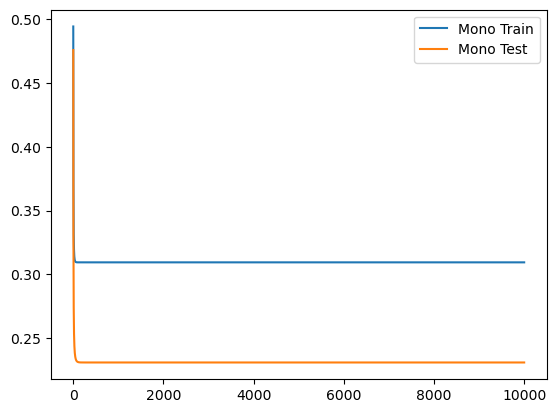

In [17]:
plt.plot(costs_train_mono, label="Mono Train")
plt.plot(costs_test_mono, label="Mono Test")
plt.legend()
plt.show()

In [18]:
thetas = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]

costs_train = np.zeros((T, Nb_model))
costs_test = np.zeros((T, Nb_model))


for i in range(T):
    thetas = stepForward(thetas, X_agent_augmented, Y_agent)
    for j in range(Nb_model):
            costs_train[i,j] = cost(thetas[j], X_agent_augmented[j], Y_agent[j])
            costs_test[i,j] = cost(thetas[j], X_test_augmented, Y_test)
    if i % 1000 == 0 :
        print(f'Iteration {i+1} : Train: {np.mean(costs_train[i]):.4f} and {np.std(costs_train[i]):.4f} | Test: {np.mean(costs_test[i]):.4f} and {np.std(costs_test[i]):.4f}')

Iteration 1 : Train: 0.4569 and 0.1696 | Test: 0.6374 and 0.0819
Iteration 1001 : Train: 0.2119 and 0.1710 | Test: 0.2048 and 0.0096
Iteration 2001 : Train: 0.2054 and 0.1719 | Test: 0.1910 and 0.0045
Iteration 3001 : Train: 0.2016 and 0.1703 | Test: 0.1850 and 0.0034
Iteration 4001 : Train: 0.1986 and 0.1680 | Test: 0.1813 and 0.0032
Iteration 5001 : Train: 0.1960 and 0.1654 | Test: 0.1785 and 0.0032
Iteration 6001 : Train: 0.1938 and 0.1630 | Test: 0.1763 and 0.0032
Iteration 7001 : Train: 0.1917 and 0.1607 | Test: 0.1745 and 0.0033
Iteration 8001 : Train: 0.1899 and 0.1585 | Test: 0.1729 and 0.0033
Iteration 9001 : Train: 0.1882 and 0.1565 | Test: 0.1716 and 0.0034


In [ ]:
# Alternative : choix aléatoire des agents

thetas = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]
costs_train = np.zeros((T, Nb_model))
costs_test = np.zeros((T, Nb_model))


# option 1 : randint avec quota global
import random as rd

tracking  = np.zeros(Nb_model) # pour mesurer le nombre de fois que chaque agent passe

print(np.zeros)

for i in range (T) :
    j = rd.randint(0, Nb_model)
    tracking[j] += 1
    costs_train[i,j] = cost(thetas[j], X_agent_augmented[j], Y_agent[j])
    costs_test[i,j] = cost(thetas[j], X_test_augmented, Y_test)
    if i % 1000 == 0 :
        print(f'Iteration {i+1} : Train: {np.mean(costs_train[i]):.4f} and {np.std(costs_train[i]):.4f} | Test: {np.mean(costs_test[i]):.4f} and {np.std(costs_test[i]):.4f}')
        
print(tracking)

In [ ]:
# option 2 : pondérer les agents

thetas = [np.zeros(X_agent_augmented[i].shape[1]) for i in range(Nb_model)]
costs_train = np.zeros((T, Nb_model))
costs_test = np.zeros((T, Nb_model))
tracking  = np.zeros(Nb_model)

# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(Nb_model)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]
for i in range (len(c)) :
    coeffs_pond = c[i]/c_tot

for i in range (T) :
    j = np.random.choice(coeffs_pond)
    tracking[j] += 1
    costs_train[i,j] = cost(thetas[j], X_agent_augmented[j], Y_agent[j])
    costs_test[i,j] = cost(thetas[j], X_test_augmented, Y_test)
    if i % 1000 == 0 :
        print(f'Iteration {i+1} : Train: {np.mean(costs_train[i]):.4f} and {np.std(costs_train[i]):.4f} | Test: {np.mean(costs_test[i]):.4f} and {np.std(costs_test[i]):.4f}')
        
print(tracking)

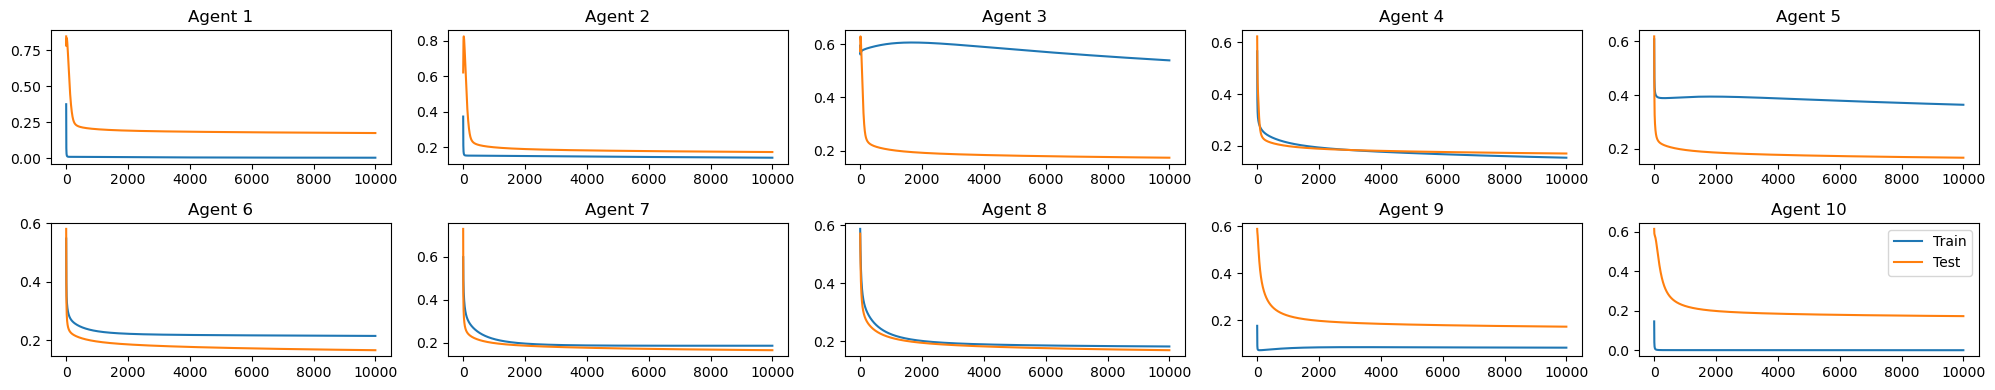

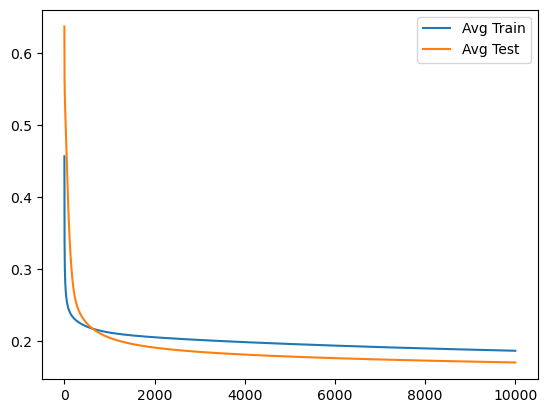

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=int(Nb_model/2), figsize=(20, 4))

for i in range(Nb_model):
    row = i // (Nb_model // 2)
    col = i % (Nb_model // 2)
    colors = ['blue' if y== 0 else 'yellow' for y in Y_agent[i]]
    axes[row, col].plot(costs_train[:, i], label='Train')
    axes[row, col].plot(costs_test[:, i], label='Test')
    axes[row, col].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.legend()
plt.show()


plt.plot(np.mean(costs_train, axis=1), label="Avg Train")
plt.plot(np.mean(costs_test, axis=1), label="Avg Test")
plt.legend()
plt.show()